# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_height, image_width, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z', )
    lr = tf.placeholder(tf.float32, name='lr')

    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/ubuntu/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/ubuntu/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/zmq/eventloop

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [15]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.nn.dropout(relu2, 0.5)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.nn.dropout(relu3, 0.5)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [16]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = True
    alpha = 0.1
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, units=7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, shape=(-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='SAME')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=1, padding='SAME')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, 0.5)

        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=1, padding='SAME')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)

        
        # Output layer, 32x32x3
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='SAME')
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    smooth_factor = 0.1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)
                                               * (1 - smooth_factor)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [x for x in t_vars if x.name.startswith('discriminator')]
    g_vars = [x for x in t_vars if x.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [22]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #print(data_shape)
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    losses, samples = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            print(epoch_i)
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                
                # Sample random noise for G
                # batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_z = np.random.normal(0, 1, size=(batch_size, z_dim))
                # Sample from gaussian distro. Ref: https://github.com/soumith/ganhacks#3-use-a-spherical-z

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                
                if steps % 25 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

0
Epoch 1/2... Discriminator Loss: 0.6788... Generator Loss: 2.4985
Epoch 1/2... Discriminator Loss: 1.3148... Generator Loss: 1.2694
Epoch 1/2... Discriminator Loss: 2.5410... Generator Loss: 0.2901
Epoch 1/2... Discriminator Loss: 1.5276... Generator Loss: 1.4842


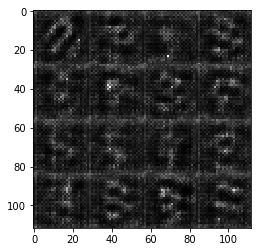

Epoch 1/2... Discriminator Loss: 1.6793... Generator Loss: 0.6873
Epoch 1/2... Discriminator Loss: 1.1281... Generator Loss: 1.5752
Epoch 1/2... Discriminator Loss: 1.3287... Generator Loss: 0.6972
Epoch 1/2... Discriminator Loss: 1.4096... Generator Loss: 1.5757


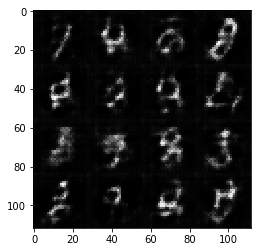

Epoch 1/2... Discriminator Loss: 1.6018... Generator Loss: 1.8017
Epoch 1/2... Discriminator Loss: 1.2445... Generator Loss: 0.7686
Epoch 1/2... Discriminator Loss: 1.8206... Generator Loss: 0.3047
Epoch 1/2... Discriminator Loss: 1.4344... Generator Loss: 0.6212


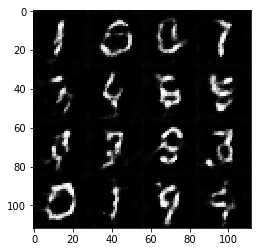

Epoch 1/2... Discriminator Loss: 1.3483... Generator Loss: 0.7511
Epoch 1/2... Discriminator Loss: 1.3418... Generator Loss: 1.0325
Epoch 1/2... Discriminator Loss: 1.2453... Generator Loss: 1.2127
Epoch 1/2... Discriminator Loss: 1.3911... Generator Loss: 0.7585


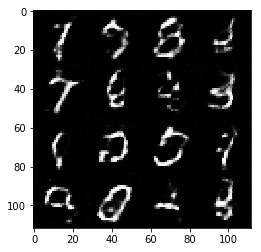

Epoch 1/2... Discriminator Loss: 1.3084... Generator Loss: 1.0616
Epoch 1/2... Discriminator Loss: 1.3480... Generator Loss: 1.6047
Epoch 1/2... Discriminator Loss: 1.2023... Generator Loss: 1.3614
Epoch 1/2... Discriminator Loss: 1.2616... Generator Loss: 0.6457


Epoch 1/2... Discriminator Loss: 1.3075... Generator Loss: 0.8239
Epoch 1/2... Discriminator Loss: 1.2374... Generator Loss: 0.9149
Epoch 1/2... Discriminator Loss: 1.2553... Generator Loss: 0.7777
Epoch 1/2... Discriminator Loss: 1.4173... Generator Loss: 2.0572


Epoch 1/2... Discriminator Loss: 1.4142... Generator Loss: 0.6073
Epoch 1/2... Discriminator Loss: 1.1505... Generator Loss: 1.0927
Epoch 1/2... Discriminator Loss: 1.3601... Generator Loss: 1.4318
Epoch 1/2... Discriminator Loss: 1.2915... Generator Loss: 0.9454


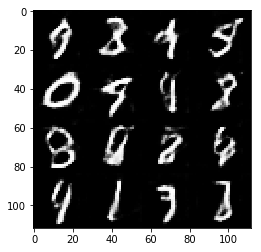

Epoch 1/2... Discriminator Loss: 1.2148... Generator Loss: 1.3383
Epoch 1/2... Discriminator Loss: 1.2348... Generator Loss: 0.8872
Epoch 1/2... Discriminator Loss: 1.3601... Generator Loss: 1.5163
Epoch 1/2... Discriminator Loss: 1.2252... Generator Loss: 1.3024


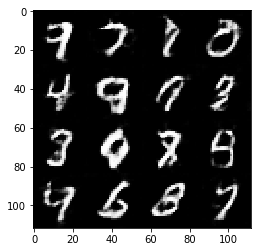

Epoch 1/2... Discriminator Loss: 1.3575... Generator Loss: 0.5686
Epoch 1/2... Discriminator Loss: 1.4244... Generator Loss: 0.6915
Epoch 1/2... Discriminator Loss: 1.3551... Generator Loss: 0.7154
Epoch 1/2... Discriminator Loss: 1.3985... Generator Loss: 1.7432


Epoch 1/2... Discriminator Loss: 2.0309... Generator Loss: 2.5269
1
Epoch 2/2... Discriminator Loss: 1.2829... Generator Loss: 0.9388
Epoch 2/2... Discriminator Loss: 1.3094... Generator Loss: 1.2132
Epoch 2/2... Discriminator Loss: 1.2134... Generator Loss: 0.7530


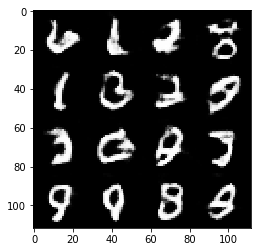

Epoch 2/2... Discriminator Loss: 1.3388... Generator Loss: 0.6115
Epoch 2/2... Discriminator Loss: 1.4424... Generator Loss: 0.7331
Epoch 2/2... Discriminator Loss: 1.2412... Generator Loss: 1.1511
Epoch 2/2... Discriminator Loss: 1.2502... Generator Loss: 1.3598


Epoch 2/2... Discriminator Loss: 1.1707... Generator Loss: 1.1609
Epoch 2/2... Discriminator Loss: 1.1845... Generator Loss: 0.9954
Epoch 2/2... Discriminator Loss: 1.3843... Generator Loss: 1.4395
Epoch 2/2... Discriminator Loss: 1.4158... Generator Loss: 0.5526


Epoch 2/2... Discriminator Loss: 1.0796... Generator Loss: 1.0531
Epoch 2/2... Discriminator Loss: 1.2396... Generator Loss: 1.2023
Epoch 2/2... Discriminator Loss: 1.2093... Generator Loss: 2.1367
Epoch 2/2... Discriminator Loss: 1.1441... Generator Loss: 0.9219


Epoch 2/2... Discriminator Loss: 1.0914... Generator Loss: 1.2125
Epoch 2/2... Discriminator Loss: 0.9990... Generator Loss: 1.2231
Epoch 2/2... Discriminator Loss: 1.1160... Generator Loss: 1.0669
Epoch 2/2... Discriminator Loss: 1.1054... Generator Loss: 0.9406


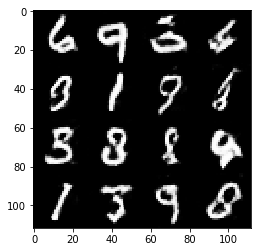

Epoch 2/2... Discriminator Loss: 1.3004... Generator Loss: 0.8232
Epoch 2/2... Discriminator Loss: 1.2527... Generator Loss: 0.8592
Epoch 2/2... Discriminator Loss: 1.2953... Generator Loss: 2.1228
Epoch 2/2... Discriminator Loss: 1.2761... Generator Loss: 1.9959


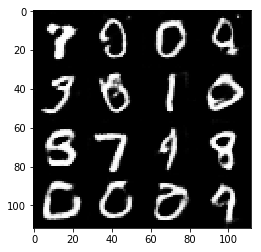

Epoch 2/2... Discriminator Loss: 1.1147... Generator Loss: 1.3055
Epoch 2/2... Discriminator Loss: 1.2904... Generator Loss: 0.6769
Epoch 2/2... Discriminator Loss: 1.2556... Generator Loss: 1.2903
Epoch 2/2... Discriminator Loss: 1.7608... Generator Loss: 2.7866


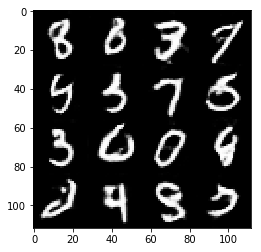

Epoch 2/2... Discriminator Loss: 1.2573... Generator Loss: 0.7928
Epoch 2/2... Discriminator Loss: 1.2999... Generator Loss: 1.0446
Epoch 2/2... Discriminator Loss: 1.2694... Generator Loss: 1.6584
Epoch 2/2... Discriminator Loss: 1.5264... Generator Loss: 0.5263


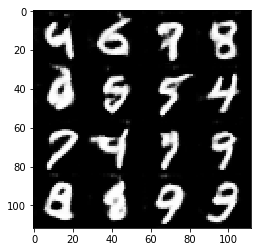

Epoch 2/2... Discriminator Loss: 1.1017... Generator Loss: 1.3642
Epoch 2/2... Discriminator Loss: 1.1350... Generator Loss: 1.3011
Epoch 2/2... Discriminator Loss: 1.3664... Generator Loss: 0.7970
Epoch 2/2... Discriminator Loss: 1.1275... Generator Loss: 1.6135


Epoch 2/2... Discriminator Loss: 1.0809... Generator Loss: 1.1051
Epoch 2/2... Discriminator Loss: 1.1356... Generator Loss: 1.2533


In [23]:
batch_size = 64
z_dim = 64
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

0
Epoch 1/1... Discriminator Loss: 3.0237... Generator Loss: 6.4220
Epoch 1/1... Discriminator Loss: 1.2153... Generator Loss: 1.6548
Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 0.5438
Epoch 1/1... Discriminator Loss: 1.1660... Generator Loss: 2.4220


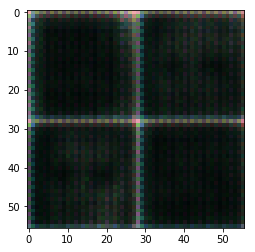

Epoch 1/1... Discriminator Loss: 1.5066... Generator Loss: 0.4558
Epoch 1/1... Discriminator Loss: 1.0851... Generator Loss: 0.7820
Epoch 1/1... Discriminator Loss: 2.1456... Generator Loss: 0.2125
Epoch 1/1... Discriminator Loss: 1.0853... Generator Loss: 0.7849


Epoch 1/1... Discriminator Loss: 2.0613... Generator Loss: 0.2444
Epoch 1/1... Discriminator Loss: 1.0166... Generator Loss: 0.9747
Epoch 1/1... Discriminator Loss: 0.8598... Generator Loss: 1.1299
Epoch 1/1... Discriminator Loss: 0.8504... Generator Loss: 1.1976


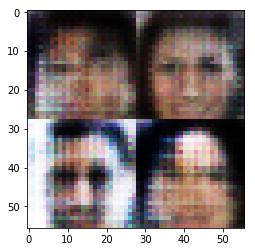

Epoch 1/1... Discriminator Loss: 1.1203... Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 1.0639... Generator Loss: 1.0247
Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 0.5367
Epoch 1/1... Discriminator Loss: 1.1669... Generator Loss: 0.7697


Epoch 1/1... Discriminator Loss: 0.9399... Generator Loss: 1.2500
Epoch 1/1... Discriminator Loss: 1.7122... Generator Loss: 0.3136
Epoch 1/1... Discriminator Loss: 1.1408... Generator Loss: 0.9545
Epoch 1/1... Discriminator Loss: 1.0895... Generator Loss: 0.7161


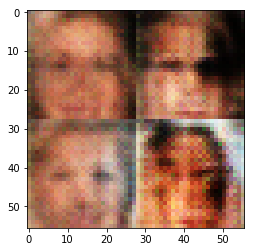

Epoch 1/1... Discriminator Loss: 0.9333... Generator Loss: 1.0539
Epoch 1/1... Discriminator Loss: 1.0804... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.1921... Generator Loss: 0.5994
Epoch 1/1... Discriminator Loss: 1.1507... Generator Loss: 1.0982


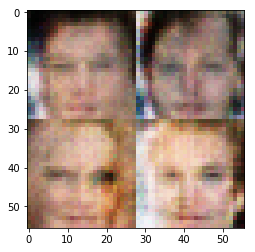

Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 1.3483
Epoch 1/1... Discriminator Loss: 1.2051... Generator Loss: 1.7010
Epoch 1/1... Discriminator Loss: 1.9420... Generator Loss: 0.2499
Epoch 1/1... Discriminator Loss: 1.6865... Generator Loss: 0.3433


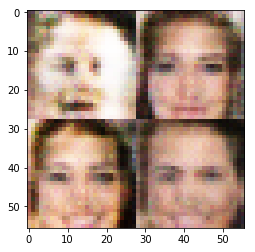

Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.4608
Epoch 1/1... Discriminator Loss: 1.2374... Generator Loss: 0.5663
Epoch 1/1... Discriminator Loss: 1.6024... Generator Loss: 2.5821
Epoch 1/1... Discriminator Loss: 1.7799... Generator Loss: 3.1513


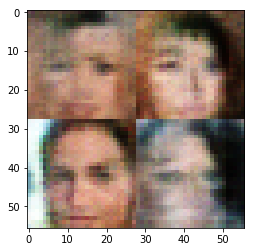

Epoch 1/1... Discriminator Loss: 1.2436... Generator Loss: 0.6351
Epoch 1/1... Discriminator Loss: 1.3211... Generator Loss: 2.3578
Epoch 1/1... Discriminator Loss: 1.8273... Generator Loss: 0.2657
Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 1.3293


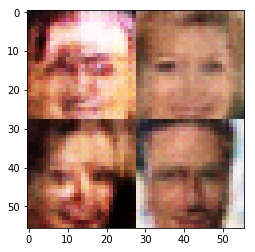

Epoch 1/1... Discriminator Loss: 1.1811... Generator Loss: 0.6739
Epoch 1/1... Discriminator Loss: 1.8429... Generator Loss: 0.2656
Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 0.6129
Epoch 1/1... Discriminator Loss: 1.0241... Generator Loss: 0.7915


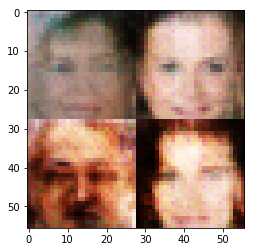

Epoch 1/1... Discriminator Loss: 1.7283... Generator Loss: 0.3005
Epoch 1/1... Discriminator Loss: 2.4806... Generator Loss: 0.1409
Epoch 1/1... Discriminator Loss: 1.2575... Generator Loss: 0.5594
Epoch 1/1... Discriminator Loss: 1.2385... Generator Loss: 1.1169


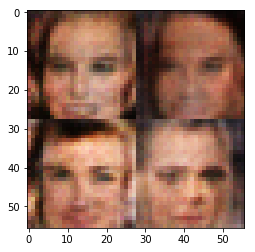

Epoch 1/1... Discriminator Loss: 1.4630... Generator Loss: 0.4697
Epoch 1/1... Discriminator Loss: 1.1385... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.0829... Generator Loss: 0.8239
Epoch 1/1... Discriminator Loss: 1.6527... Generator Loss: 2.7885


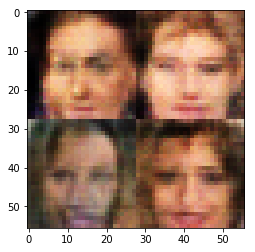

Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 0.5177
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 2.2898
Epoch 1/1... Discriminator Loss: 1.1523... Generator Loss: 1.6924
Epoch 1/1... Discriminator Loss: 1.7171... Generator Loss: 0.3236


Epoch 1/1... Discriminator Loss: 1.2779... Generator Loss: 2.2791
Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 0.4321
Epoch 1/1... Discriminator Loss: 1.7383... Generator Loss: 0.3022
Epoch 1/1... Discriminator Loss: 1.0936... Generator Loss: 0.8052


Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.4997
Epoch 1/1... Discriminator Loss: 1.1085... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.0838... Generator Loss: 0.8539
Epoch 1/1... Discriminator Loss: 1.1454... Generator Loss: 0.9017


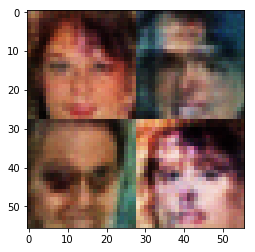

Epoch 1/1... Discriminator Loss: 2.0191... Generator Loss: 0.2311
Epoch 1/1... Discriminator Loss: 1.2118... Generator Loss: 0.6446
Epoch 1/1... Discriminator Loss: 1.6900... Generator Loss: 2.5917
Epoch 1/1... Discriminator Loss: 1.4787... Generator Loss: 0.4329


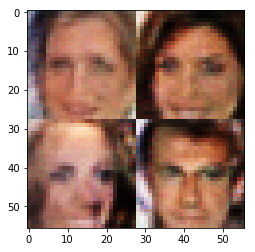

Epoch 1/1... Discriminator Loss: 1.6501... Generator Loss: 0.3516
Epoch 1/1... Discriminator Loss: 1.8075... Generator Loss: 2.8206
Epoch 1/1... Discriminator Loss: 1.9999... Generator Loss: 0.2471
Epoch 1/1... Discriminator Loss: 1.1797... Generator Loss: 0.7028


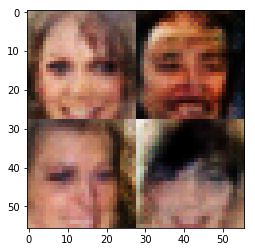

Epoch 1/1... Discriminator Loss: 1.2916... Generator Loss: 1.9177


KeyboardInterrupt: 

In [47]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, 'RGB')#celeba_dataset.image_mode)

0
Epoch 1/1... Discriminator Loss: 1.2985... Generator Loss: 1.4318
Epoch 1/1... Discriminator Loss: 1.0158... Generator Loss: 1.4149
Epoch 1/1... Discriminator Loss: 0.7592... Generator Loss: 3.1509
Epoch 1/1... Discriminator Loss: 1.0294... Generator Loss: 1.5980


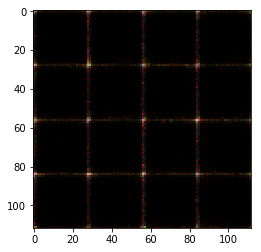

Epoch 1/1... Discriminator Loss: 0.8292... Generator Loss: 2.1469
Epoch 1/1... Discriminator Loss: 1.8421... Generator Loss: 0.4340
Epoch 1/1... Discriminator Loss: 0.9257... Generator Loss: 1.4671
Epoch 1/1... Discriminator Loss: 0.5746... Generator Loss: 3.3496


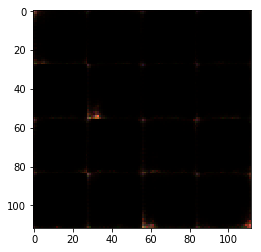

Epoch 1/1... Discriminator Loss: 1.1144... Generator Loss: 1.7432
Epoch 1/1... Discriminator Loss: 1.0982... Generator Loss: 2.6062
Epoch 1/1... Discriminator Loss: 0.7601... Generator Loss: 2.2951
Epoch 1/1... Discriminator Loss: 1.8086... Generator Loss: 5.4732


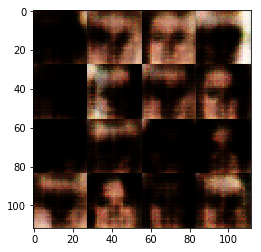

Epoch 1/1... Discriminator Loss: 0.7065... Generator Loss: 2.0543
Epoch 1/1... Discriminator Loss: 2.3479... Generator Loss: 4.9098
Epoch 1/1... Discriminator Loss: 1.2037... Generator Loss: 1.2140
Epoch 1/1... Discriminator Loss: 0.9409... Generator Loss: 1.3883


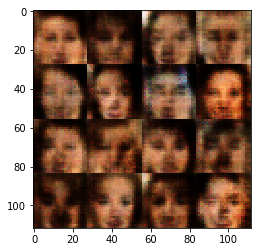

Epoch 1/1... Discriminator Loss: 0.9943... Generator Loss: 1.5894
Epoch 1/1... Discriminator Loss: 0.8449... Generator Loss: 2.1388
Epoch 1/1... Discriminator Loss: 0.9245... Generator Loss: 2.0370
Epoch 1/1... Discriminator Loss: 0.8850... Generator Loss: 1.4117


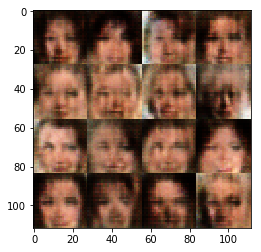

Epoch 1/1... Discriminator Loss: 0.9464... Generator Loss: 1.4207
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.8891
Epoch 1/1... Discriminator Loss: 1.1391... Generator Loss: 0.9779
Epoch 1/1... Discriminator Loss: 1.0296... Generator Loss: 1.3300


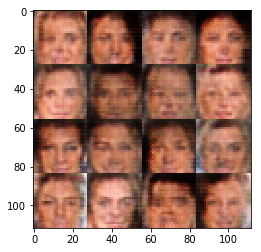

Epoch 1/1... Discriminator Loss: 1.2467... Generator Loss: 0.9790
Epoch 1/1... Discriminator Loss: 1.1210... Generator Loss: 1.8401
Epoch 1/1... Discriminator Loss: 1.0841... Generator Loss: 1.2860
Epoch 1/1... Discriminator Loss: 1.0657... Generator Loss: 1.9092


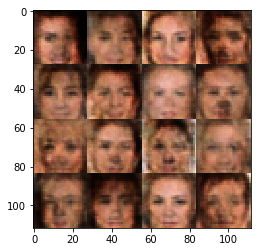

Epoch 1/1... Discriminator Loss: 1.1728... Generator Loss: 1.1535
Epoch 1/1... Discriminator Loss: 1.0896... Generator Loss: 1.2005
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 0.9327... Generator Loss: 1.4855


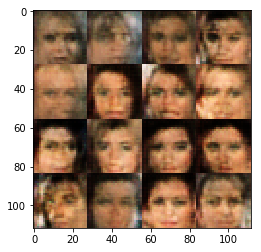

Epoch 1/1... Discriminator Loss: 1.2105... Generator Loss: 1.4778
Epoch 1/1... Discriminator Loss: 1.1487... Generator Loss: 1.2480
Epoch 1/1... Discriminator Loss: 1.1045... Generator Loss: 1.4381
Epoch 1/1... Discriminator Loss: 1.3069... Generator Loss: 2.5459


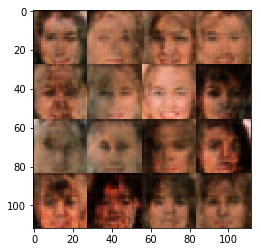

Epoch 1/1... Discriminator Loss: 1.1202... Generator Loss: 1.3824
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 1.8871
Epoch 1/1... Discriminator Loss: 1.5544... Generator Loss: 0.6271
Epoch 1/1... Discriminator Loss: 1.0376... Generator Loss: 1.3861


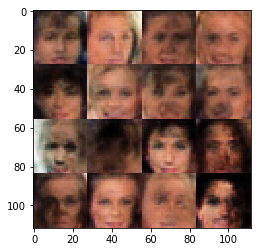

Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.0947... Generator Loss: 1.0723
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.8905
Epoch 1/1... Discriminator Loss: 1.0508... Generator Loss: 1.2165


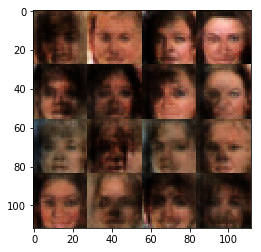

Epoch 1/1... Discriminator Loss: 1.1679... Generator Loss: 1.2364
Epoch 1/1... Discriminator Loss: 1.2303... Generator Loss: 0.8758
Epoch 1/1... Discriminator Loss: 1.0713... Generator Loss: 2.0000
Epoch 1/1... Discriminator Loss: 1.2843... Generator Loss: 0.7281


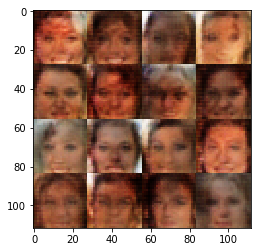

Epoch 1/1... Discriminator Loss: 1.1189... Generator Loss: 1.0553
Epoch 1/1... Discriminator Loss: 1.0688... Generator Loss: 2.2232
Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 1.0233
Epoch 1/1... Discriminator Loss: 1.1673... Generator Loss: 1.3291


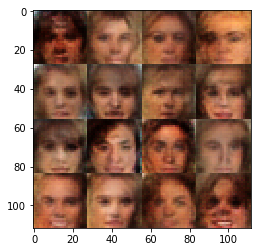

Epoch 1/1... Discriminator Loss: 1.1167... Generator Loss: 1.4197
Epoch 1/1... Discriminator Loss: 1.1256... Generator Loss: 0.9328
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 1.6780
Epoch 1/1... Discriminator Loss: 1.2103... Generator Loss: 0.8256


Epoch 1/1... Discriminator Loss: 1.0927... Generator Loss: 1.1994
Epoch 1/1... Discriminator Loss: 1.2535... Generator Loss: 1.7878
Epoch 1/1... Discriminator Loss: 1.1204... Generator Loss: 1.4127
Epoch 1/1... Discriminator Loss: 1.1701... Generator Loss: 1.0015


Epoch 1/1... Discriminator Loss: 1.2701... Generator Loss: 0.8916
Epoch 1/1... Discriminator Loss: 1.1903... Generator Loss: 1.1649
Epoch 1/1... Discriminator Loss: 1.1007... Generator Loss: 0.9739
Epoch 1/1... Discriminator Loss: 1.1372... Generator Loss: 1.0250


Epoch 1/1... Discriminator Loss: 1.0561... Generator Loss: 1.2408
Epoch 1/1... Discriminator Loss: 1.1278... Generator Loss: 1.3143
Epoch 1/1... Discriminator Loss: 1.1133... Generator Loss: 0.9570
Epoch 1/1... Discriminator Loss: 1.0847... Generator Loss: 1.4640


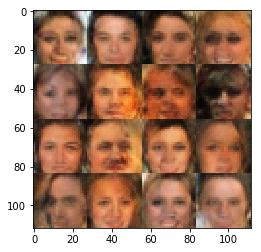

Epoch 1/1... Discriminator Loss: 1.2356... Generator Loss: 1.6060
Epoch 1/1... Discriminator Loss: 1.1863... Generator Loss: 0.9536
Epoch 1/1... Discriminator Loss: 1.1937... Generator Loss: 0.8681
Epoch 1/1... Discriminator Loss: 1.5378... Generator Loss: 0.6370


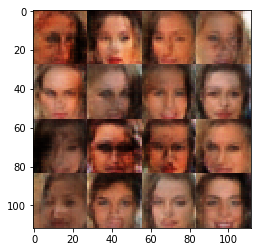

Epoch 1/1... Discriminator Loss: 1.1783... Generator Loss: 1.6726
Epoch 1/1... Discriminator Loss: 1.0886... Generator Loss: 1.4657
Epoch 1/1... Discriminator Loss: 1.1560... Generator Loss: 1.1454
Epoch 1/1... Discriminator Loss: 1.7379... Generator Loss: 0.3748


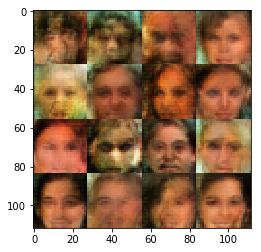

Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 1.5356
Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 0.8916
Epoch 1/1... Discriminator Loss: 0.8748... Generator Loss: 1.6613
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.7533


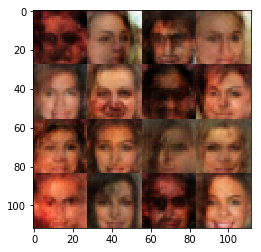

Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 1.3096
Epoch 1/1... Discriminator Loss: 1.1490... Generator Loss: 1.2841
Epoch 1/1... Discriminator Loss: 1.2682... Generator Loss: 0.9919
Epoch 1/1... Discriminator Loss: 1.1712... Generator Loss: 0.8018


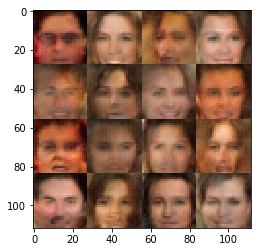

Epoch 1/1... Discriminator Loss: 1.1252... Generator Loss: 1.3253
Epoch 1/1... Discriminator Loss: 1.2161... Generator Loss: 1.1108
Epoch 1/1... Discriminator Loss: 1.1690... Generator Loss: 1.2349
Epoch 1/1... Discriminator Loss: 1.2670... Generator Loss: 0.8255


Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 1.3019
Epoch 1/1... Discriminator Loss: 1.1559... Generator Loss: 1.1145
Epoch 1/1... Discriminator Loss: 1.1183... Generator Loss: 1.2942
Epoch 1/1... Discriminator Loss: 1.2720... Generator Loss: 1.3438


Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 0.9635
Epoch 1/1... Discriminator Loss: 1.2943... Generator Loss: 0.8257
Epoch 1/1... Discriminator Loss: 1.5080... Generator Loss: 1.1443
Epoch 1/1... Discriminator Loss: 1.1775... Generator Loss: 1.0691


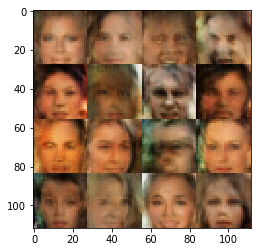

Epoch 1/1... Discriminator Loss: 1.2706... Generator Loss: 0.9721
Epoch 1/1... Discriminator Loss: 1.1062... Generator Loss: 1.2803
Epoch 1/1... Discriminator Loss: 1.0964... Generator Loss: 1.1470
Epoch 1/1... Discriminator Loss: 1.1574... Generator Loss: 0.9643


Epoch 1/1... Discriminator Loss: 1.1338... Generator Loss: 1.1062
Epoch 1/1... Discriminator Loss: 1.1503... Generator Loss: 1.0676
Epoch 1/1... Discriminator Loss: 1.1692... Generator Loss: 1.1762
Epoch 1/1... Discriminator Loss: 1.1547... Generator Loss: 1.0408


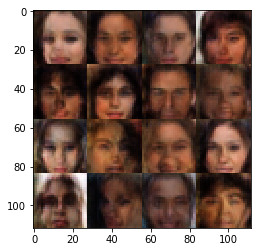

Epoch 1/1... Discriminator Loss: 1.1879... Generator Loss: 0.9473
Epoch 1/1... Discriminator Loss: 1.1479... Generator Loss: 0.8635
Epoch 1/1... Discriminator Loss: 1.1436... Generator Loss: 1.4006
Epoch 1/1... Discriminator Loss: 1.2945... Generator Loss: 0.9602


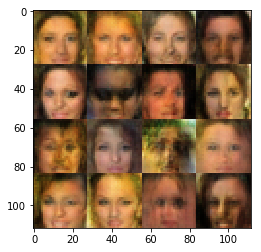

Epoch 1/1... Discriminator Loss: 1.2332... Generator Loss: 1.1864
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 1.5349
Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 1.1979... Generator Loss: 1.0276


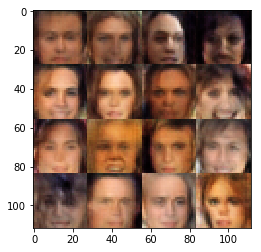

Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 1.1615
Epoch 1/1... Discriminator Loss: 1.1625... Generator Loss: 1.2783
Epoch 1/1... Discriminator Loss: 1.3109... Generator Loss: 0.9424
Epoch 1/1... Discriminator Loss: 1.2819... Generator Loss: 0.8821


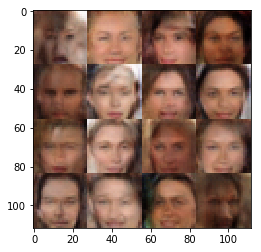

Epoch 1/1... Discriminator Loss: 1.2299... Generator Loss: 0.9087
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.7263
Epoch 1/1... Discriminator Loss: 1.1753... Generator Loss: 1.3895
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.8234


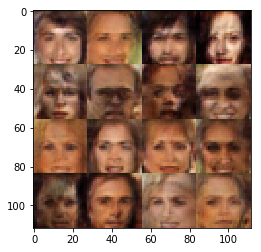

Epoch 1/1... Discriminator Loss: 1.4484... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 1.0203... Generator Loss: 1.0116
Epoch 1/1... Discriminator Loss: 1.2014... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 1.2889... Generator Loss: 0.7851


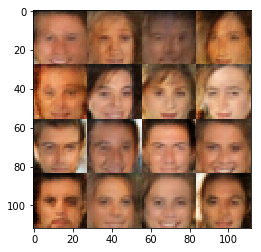

Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 1.0090


KeyboardInterrupt: 

In [24]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, 'RGB')#celeba_dataset.image_mode)

In [ ]:
# The above one looks better.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.